In [1]:
cd ..

/home/janek/reasonable-embeddings


In [3]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics
from sklearn.decomposition import PCA
from tqdm import tqdm

from src.reasoner_mod import *
from src.simplefact import *
from src.simplefact.syntax import *
from src.reasoner import *
from src.generate import *
from src.utils import *
from src.vis import *

seed = 2022

In [4]:
onto_paths = 'african-wildlife.ofn exchangemodel-noimport.ofn stuff-noimport.ofn swo-noimport.ofn ontodt-noimport.ofn pizza.ofn'.split()
onto_names = 'wildlife demacare stuff swo ontodt pizza'.split()
ontos = []
facts = []
for path in onto_paths:
    onto = load_ofn('local/out/dataset/' + path, silent=True)
    fact = Reasoner.from_onto(onto, timeout=None)
    facts.append(fact)
    ontos.append(onto)
    print(path, '\t', onto)

african-wildlife.ofn 	 <Onto 30 concepts, 5 roles, 49 axioms>
exchangemodel-noimport.ofn 	 <Onto 260 concepts, 53 roles, 369 axioms>
stuff-noimport.ofn 	 <Onto 192 concepts, 46 roles, 314 axioms>


FaCT++.Kernel: Reasoner for the SROIQ(D) Description Logic, 64-bit
Copyright (C) Dmitry Tsarkov, 2002-2017. Version 1.7.0-SNAPSHOT (01 January 2017)


swo-noimport.ofn 	 <Onto 4067 concepts, 39 roles, 7140 axioms>
ontodt-noimport.ofn 	 <Onto 405 concepts, 8 roles, 921 axioms>
pizza.ofn 	 <Onto 99 concepts, 4 roles, 287 axioms>


In [5]:
def make_dataset(onto, fact, n_queries=32_000):
    rng = np.random.default_rng(seed)
    Nc, Nr = onto.n_concepts, onto.n_roles
    gen = AxiomGenerator(rng=rng, n_concepts=Nc, n_roles=Nr, max_depth=4, p_atomic=0.95)

    queries, answers, qset = [], [], set()
    while len(queries) < n_queries:
        axiom = gen()
        axiom_core = core(axiom)
        if axiom_core in qset: continue
        answer = fact.check_axiom(axiom)
        queries.append(axiom_core); answers.append(int(answer)); qset.add(axiom_core)
        
    return queries, answers

idx_te, X_te, y_te = [], [], []
for i, (onto, fact, onto_name) in enumerate(zip(ontos, facts, onto_names)):
    X_te_onto, y_te_onto = make_dataset(onto, fact)
    idx_te += [i]*len(X_te_onto)
    print(onto_name, '- balance', np.round(np.mean(y_te_onto), 4))
    X_te += X_te_onto
    y_te += y_te_onto
    
rng = np.random.default_rng(seed)
data = idx_te, X_te, y_te = jointshuffle(rng, idx_te, X_te, y_te)

wildlife - balance 0.1202
demacare - balance 0.0423
stuff - balance 0.2313
swo - balance 0.2884
ontodt - balance 0.0892
pizza - balance 0.4123


In [8]:
ts = timestr()

emb_size = 10
embs_params = dict(emb_size=emb_size)
head_params = dict(emb_size=emb_size, hidden_size=16)
train_params = dict(epoch_count=10, batch_size=32)


T.manual_seed(seed)
transfer_r_embs = EmbeddingLayer.from_ontos(ontos, emb_size=emb_size)
transfer_r_head = ModifiedReasonerHead(**head_params)
transfer_r_head.load_state_dict(T.load('local/out/exp/20240630T144632/reasoner.pt'))

print('----')

print('frozen reasoner head (transfer)')
T.manual_seed(seed)
transfer_log = train_mod(data, None, transfer_r_head, transfer_r_embs, freeze_reasoner=True, run_name='frozen transfer', **train_params)


----
frozen reasoner head (transfer)
train epoch 00/10 | batch 6001/6000 | loss 1.0126 | val loss 1.0126 | acc 0.6874 | f1 0.4048 | prec 0.3242 | recall 0.5388 | roc auc 0.6872 | pr auc 0.4565 | elapsed 234.82s
train epoch 01/10 | batch 6001/6000 | loss 0.4741 | val loss 0.2502 | acc 0.9067 | f1 0.7575 | prec 0.7771 | recall 0.7390 | roc auc 0.9340 | pr auc 0.8295 | elapsed 458.79s
train epoch 02/10 | batch 6001/6000 | loss 0.2200 | val loss 0.1795 | acc 0.9359 | f1 0.8330 | prec 0.8571 | recall 0.8103 | roc auc 0.9641 | pr auc 0.9010 | elapsed 444.22s
train epoch 03/10 | batch 6001/6000 | loss 0.1768 | val loss 0.1555 | acc 0.9447 | f1 0.8562 | prec 0.8795 | recall 0.8341 | roc auc 0.9730 | pr auc 0.9226 | elapsed 441.95s
train epoch 04/10 | batch 6001/6000 | loss 0.1585 | val loss 0.1431 | acc 0.9502 | f1 0.8705 | prec 0.8942 | recall 0.8480 | roc auc 0.9771 | pr auc 0.9327 | elapsed 459.40s
train epoch 05/10 | batch 6001/6000 | loss 0.1480 | val loss 0.1350 | acc 0.9534 | f1 0.8787 

In [9]:
ts = timestr()

emb_size = 10
embs_params = dict(emb_size=emb_size)
head_params = dict(emb_size=emb_size, hidden_size=16)
train_params = dict(epoch_count=10, batch_size=32)

T.manual_seed(seed)
transfer_r_orig_embs = EmbeddingLayer.from_ontos(ontos, emb_size=emb_size)
transfer_r_orig_head = ReasonerHead(**head_params)
transfer_r_orig_head.load_state_dict(T.load('local/out/exp/20220715T194304/reasoner.pt'))


print('frozen reasoner head (transfer)')
T.manual_seed(seed)
transfer_log_orig = train(data, None, transfer_r_orig_head, transfer_r_orig_embs, freeze_reasoner=True, run_name='frozen transfer original', **train_params)


frozen reasoner head (transfer)
train epoch 00/10 | batch 6001/6000 | loss 1.1313 | val loss 1.1313 | acc 0.6564 | f1 0.4636 | prec 0.3350 | recall 0.7528 | roc auc 0.7480 | pr auc 0.4909 | elapsed 80.50s
train epoch 01/10 | batch 6001/6000 | loss 0.4314 | val loss 0.2165 | acc 0.9222 | f1 0.8040 | prec 0.7992 | recall 0.8090 | roc auc 0.9490 | pr auc 0.8719 | elapsed 273.68s
train epoch 02/10 | batch 6001/6000 | loss 0.1990 | val loss 0.1700 | acc 0.9429 | f1 0.8524 | prec 0.8692 | recall 0.8361 | roc auc 0.9670 | pr auc 0.9122 | elapsed 267.65s
train epoch 03/10 | batch 6001/6000 | loss 0.1707 | val loss 0.1537 | acc 0.9483 | f1 0.8657 | prec 0.8870 | recall 0.8454 | roc auc 0.9731 | pr auc 0.9252 | elapsed 265.43s
train epoch 04/10 | batch 6001/6000 | loss 0.1577 | val loss 0.1446 | acc 0.9513 | f1 0.8734 | prec 0.8958 | recall 0.8522 | roc auc 0.9764 | pr auc 0.9322 | elapsed 261.44s
train epoch 05/10 | batch 6001/6000 | loss 0.1500 | val loss 0.1381 | acc 0.9539 | f1 0.8801 | prec

local/out/exp/20240704T171104
------
Frozen pre-trained reasoner head original
train time 2441.9960453510284
           mean     std   micro
acc      0.9601  0.0219  0.9601
prec     0.9137  0.0588  0.9148
recall   0.8439  0.1134  0.8798
f1       0.8757  0.0846  0.8970
auc_roc  0.9777  0.0156  0.9832
auc_pr   0.9285  0.0573  0.9499
------
Frozen pre-trained reasoner head
train time 3546.558350801468
           mean     std   micro
acc      0.9605  0.0229  0.9605
prec     0.9153  0.0580  0.9139
recall   0.8469  0.1133  0.8832
f1       0.8778  0.0831  0.8983
auc_roc  0.9802  0.0143  0.9851
auc_pr   0.9331  0.0550  0.9531


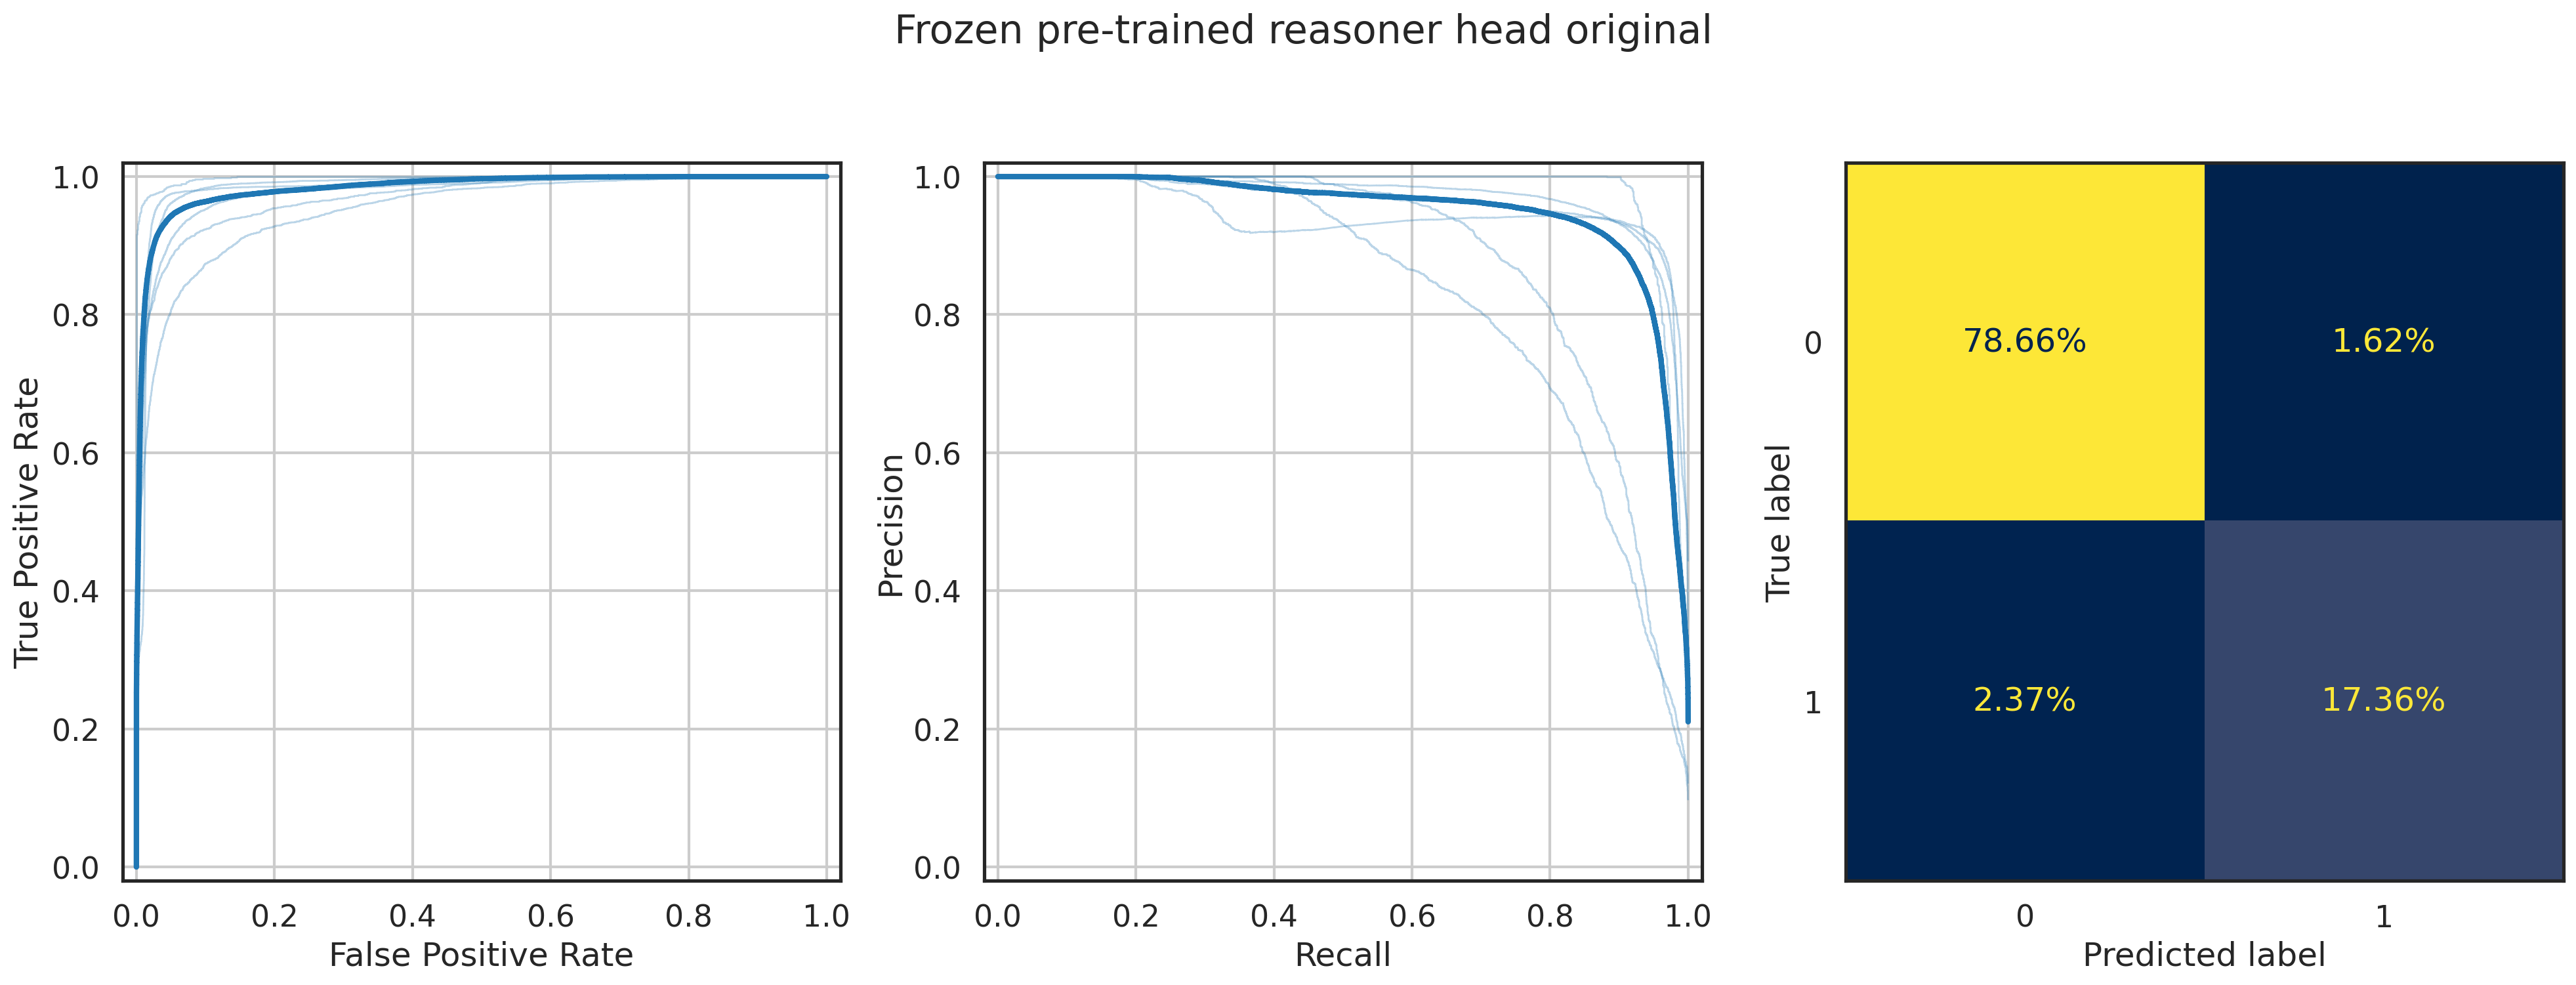

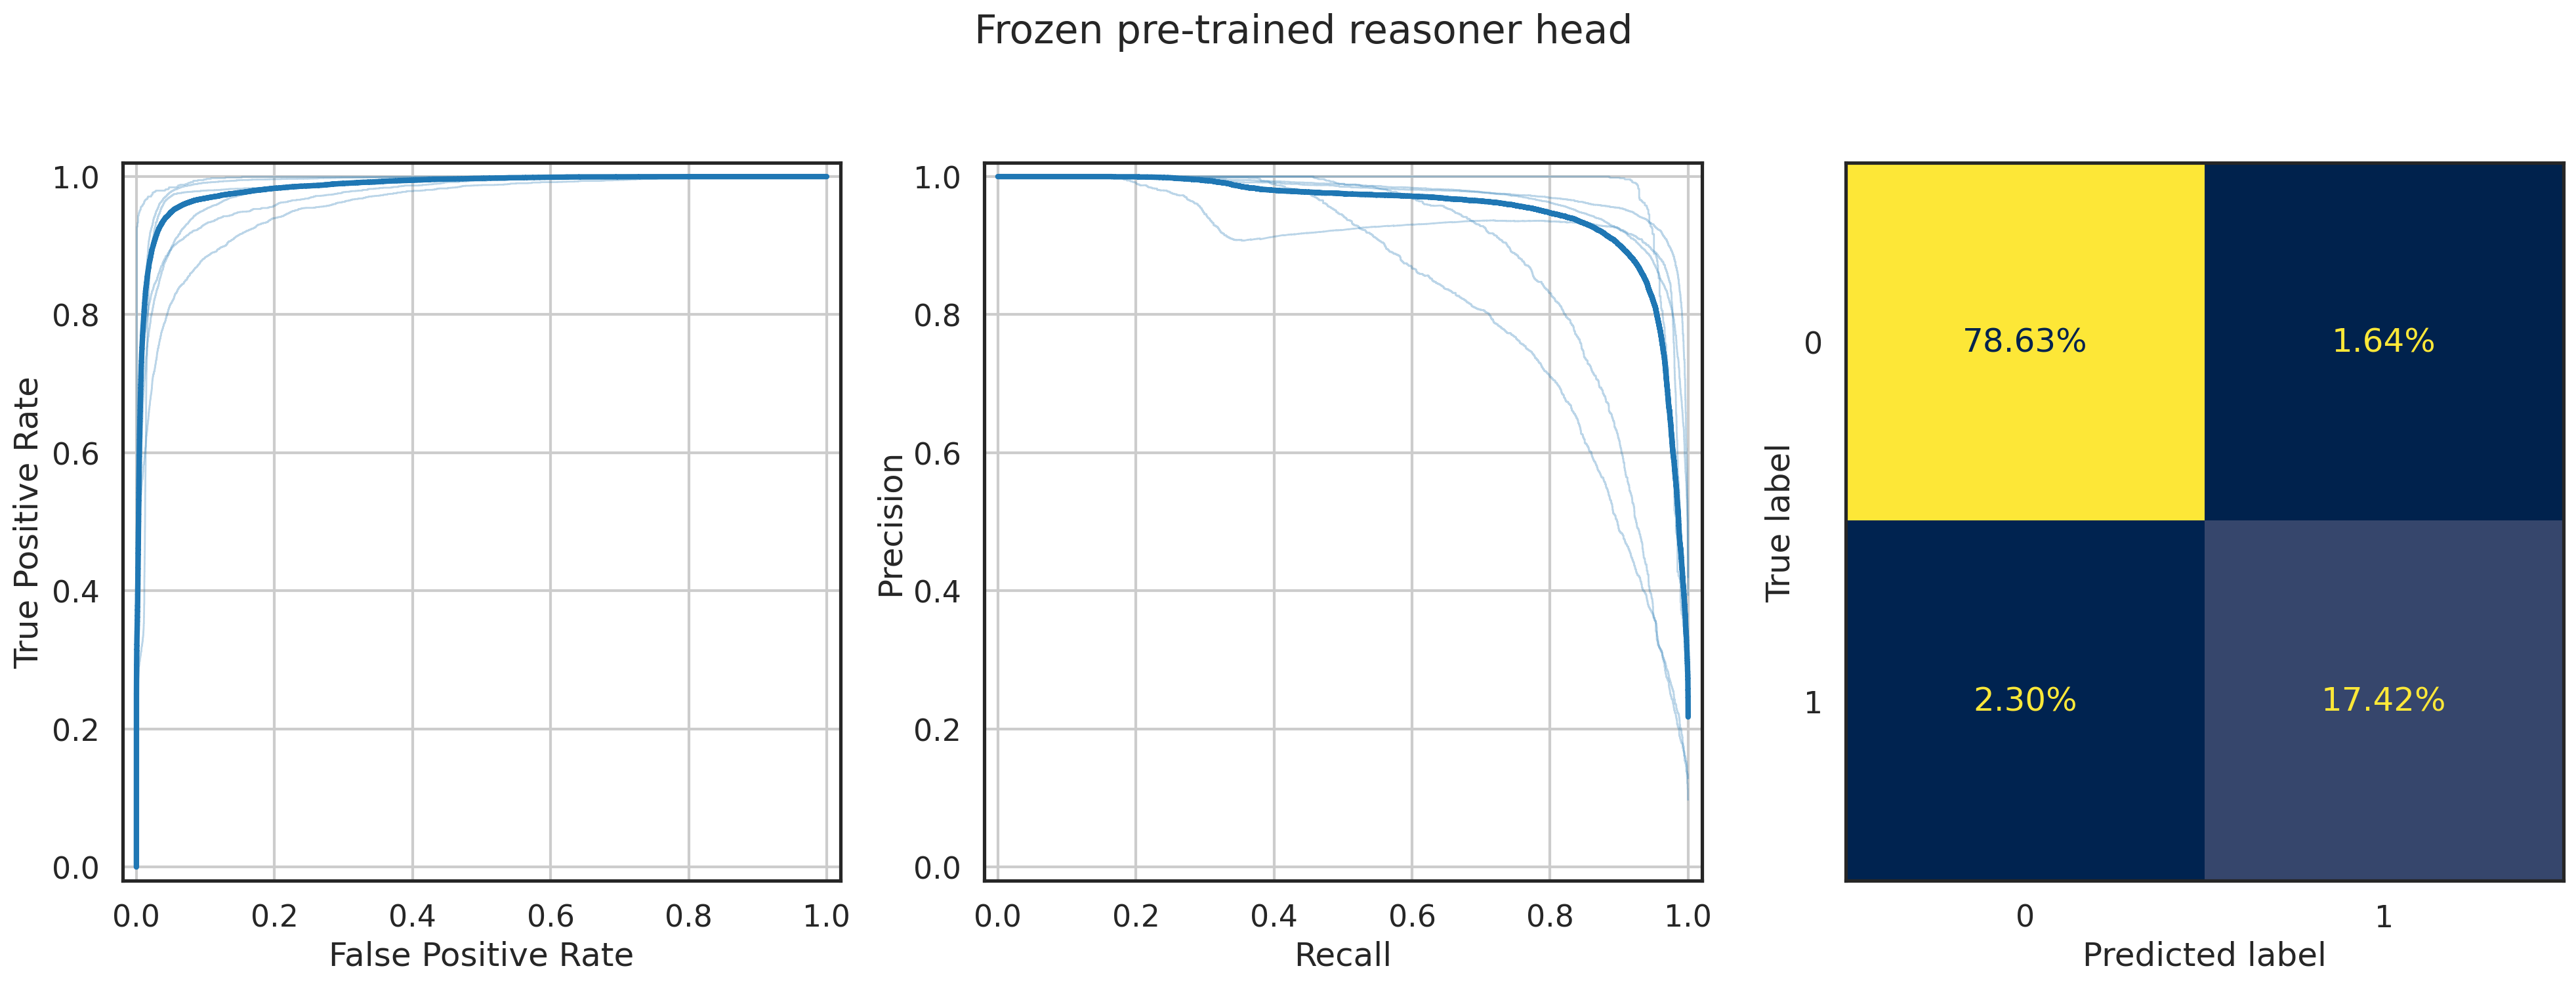

In [11]:
titles = 'Expected', 'Frozen pre-trained reasoner head original', 'Frozen pre-trained reasoner head'
logs = transfer_log_orig, transfer_log
heads = transfer_r_orig_head, transfer_r_head
embeddings = transfer_r_orig_embs, transfer_r_embs

base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

for head, embs, log, title in zip(heads, embeddings, logs, titles[1:]):
    print('------')
    with T.no_grad():
        head.eval()
        if title == 'Frozen pre-trained reasoner head original':
            _, _, Y_te = eval_batch(head, embs, X_te, y_te, idx_te)
        else:
            _, _, Y_te = eval_batch_mod(head, embs, X_te, y_te, idx_te)

    print(title)
    
    history_tr = pd.DataFrame(log.history_tr)
    test_history_by_onto = pd.DataFrame(log.history_vl_by_onto)
    test_history = pd.DataFrame(log.history_vl)
    test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te=Y_te))
    test_history.to_csv(base+f'/{title} test.csv', index=False)
    test_history_by_onto.to_csv(base+f'/{title} test by onto.csv', index=False)
    test_results.to_csv(base+f'/{title} test clas.csv', index=False)

    print('train time', history_tr.groupby('epoch').max().elapsed.sum())
    print(report(ontos, y_te, Y_te, idx_te).round(4))
    plt.suptitle(title)

In [7]:
for head, embs, log, title in zip(heads, embeddings, logs, titles[1:]):
    df = pd.DataFrame(log.history_vl_by_onto)
    df = df[df.epoch == df.epoch.max()].drop(columns=['epoch', 'run', 'elapsed'])
    df.onto = df.onto.map(onto_names.__getitem__)
    print('-'*10)
    print(title)
    #print(df.agg(['mean', 'std']).round(4).T)
    print(df.round(4))

----------
Unfrozen reasoner head
       acc      f1    prec  recall  roc_auc  pr_auc      onto
60  0.9639  0.8466  0.8697  0.8247   0.9803  0.9214  wildlife
61  0.9956  0.9449  0.9984  0.8969   0.9979  0.9772  demacare
62  0.9903  0.9789  0.9853  0.9725   0.9970  0.9921     stuff
63  0.9635  0.9377  0.9175  0.9588   0.9929  0.9808       swo
64  0.9752  0.8515  0.9187  0.7934   0.9821  0.9187    ontodt
65  0.9710  0.9647  0.9654  0.9640   0.9940  0.9920     pizza
----------
Frozen pre-trained reasoner head
       acc      f1    prec  recall  roc_auc  pr_auc      onto
60  0.9428  0.7441  0.8105  0.6877   0.9518  0.8363  wildlife
61  0.9956  0.9453  0.9984  0.8976   0.9977  0.9762  demacare
62  0.9658  0.9260  0.9258  0.9261   0.9831  0.9410     stuff
63  0.9558  0.9234  0.9179  0.9290   0.9861  0.9640       swo
64  0.9672  0.7960  0.8981  0.7148   0.9704  0.8828    ontodt
65  0.9328  0.9180  0.9218  0.9143   0.9768  0.9700     pizza
----------
Frozen random reasoner head
       acc     